In [79]:
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import BorderlineSMOTE
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('cividis')

warnings.filterwarnings('ignore')

In [80]:
train_path = os.path.join("..", "data", "input", "train.csv")
test_path = os.path.join("..", "data", "input", "test.csv")

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

df.set_index("encounter_id", inplace=True)
test_df.set_index("encounter_id", inplace=True)

In [81]:
df.head().T

encounter_id,533253,426224,634063,890610,654194
country,USA,USA,USA,USA,USA
patient_id,70110,29775006,80729253,2919042,84871971
race,Caucasian,AfricanAmerican,Caucasian,AfricanAmerican,Caucasian
gender,Female,Male,Female,Male,Female
age,[70-80),[50-60),[60-70),[60-70),[70-80)
weight,?,?,?,?,?
payer_code,?,?,?,MC,HM
outpatient_visits_in_previous_year,0,0,0,0,1
emergency_visits_in_previous_year,0,0,0,0,0
inpatient_visits_in_previous_year,2,0,1,1,0


## Data exploration

In [82]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,71236,1,USA,71236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
patient_id,71236.0,NaN,NaN,NaN,54302279.330984,38795850.347332,135.0,23396510.25,45305631.0,87558374.25,189502619.0
race,67682,6,Caucasian,50693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,71236,3,Female,38228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,67679,10,[70-80),17359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,71236,10,?,68990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payer_code,71236,18,?,28201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outpatient_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.369588,1.287469,0.0,0.0,0.0,0.0,42.0
emergency_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.196249,0.910854,0.0,0.0,0.0,0.0,76.0
inpatient_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.640154,1.267271,0.0,0.0,0.0,1.0,21.0


In [83]:
df.duplicated().sum()

0

### Checking NaNs

since we noticed that there are a lot of `?` we are going to replace all with `np.nan`, to see the quantity of missing values


In [84]:
df.replace("?", np.nan, inplace=True)
test_df.replace("?", np.nan, inplace=True)

df.isna().sum()[df.isnull().sum() > 1] / len(df) * 100

race                      7.117188
age                       4.993262
weight                   96.847100
payer_code               39.588130
admission_type            5.202426
medical_specialty        49.022966
discharge_disposition     3.635802
admission_source          6.623056
primary_diagnosis         0.022461
secondary_diagnosis       0.367792
additional_diagnosis      1.415015
glucose_test_result      94.822842
a1c_test_result          83.272503
dtype: float64

In [85]:
print("a1c", df["a1c_test_result"].unique())
print("glucose", df["glucose_test_result"].unique())

a1c [nan 'Norm' '>8' '>7']
glucose [nan '>300' 'Norm' '>200']


according to the documentation provided, the possible values in a1c and glucose tests, contain a "none".

so, the approach that we are taking is to replace the nans of these columns with a "none", since probably both of this columns could have an impact on the target variable


In [86]:
df.loc[:, ["a1c_test_result", "glucose_test_result"]] = df.loc[:, [
    "a1c_test_result", "glucose_test_result"]].replace(np.nan, "none")
test_df.loc[:, ["a1c_test_result", "glucose_test_result"]] = test_df.loc[:, [
    "a1c_test_result", "glucose_test_result"]].replace(np.nan, "none")

print("a1c", df["a1c_test_result"].unique())
print("glucose", df["glucose_test_result"].unique())

a1c ['none' 'Norm' '>8' '>7']
glucose ['none' '>300' 'Norm' '>200']


values that are not common in the feature, we will replace with np.nan


In [87]:
# here not so agree with how things are handled here, maybe do it down?
# !!! indeed handling missing values is after data exploration

# df["admission_type"].replace("Not Available", np.nan, inplace=True)
# df["admission_type"].replace("Not Mapped", np.nan, inplace=True)
# df["discharge_disposition"].replace("Not Mapped", np.nan, inplace=True)
# df["gender"].replace("Unknown/Invalid", np.nan, inplace=True)
# df["admission_source"].replace("Not Available", np.nan, inplace=True)
# df['medical_specialty'].replace('PhysicianNotFound', np.nan, inplace=True)

# test_df["admission_type"].replace("Not Available", np.nan, inplace=True)
# test_df["admission_type"].replace("Not Mapped", np.nan, inplace=True)
# test_df["discharge_disposition"].replace("Not Mapped", np.nan, inplace=True)
# test_df["gender"].replace("Unknown/Invalid", np.nan, inplace=True)
# test_df["admission_source"].replace("Not Available", np.nan, inplace=True)
# test_df['medical_specialty'].replace('PhysicianNotFound', np.nan, inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71236 entries, 533253 to 459757
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   66166 non-null  object
 3   gender                                 71236 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 2246 non-null   object
 6   payer_code                             43035 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         67530 non-null  object
 11  medical_specia

### Partitioning metric and categorical features

In [148]:
metric_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns

metric_features = metric_features.drop(["patient_id"])

print(metric_features)
print(categorical_features)

Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses'],
      dtype='object')
Index(['country', 'race', 'gender', 'age', 'weight', 'payer_code',
       'admission_type', 'medical_specialty', 'discharge_disposition',
       'admission_source', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication'],
      dtype='object')


#### Metric Features Analysis


In [90]:
metric_report = df[metric_features].describe().T
metric_report['cardinality'] = df[metric_features].nunique()

metric_report

,count,mean,std,min,25%,50%,75%,max,cardinality
outpatient_visits_in_previous_year,71236.0,0.369588,1.287469,0.0,0.0,0.0,0.0,42.0,38
emergency_visits_in_previous_year,71236.0,0.196249,0.910854,0.0,0.0,0.0,0.0,76.0,30
inpatient_visits_in_previous_year,71236.0,0.640154,1.267271,0.0,0.0,0.0,1.0,21.0,21
average_pulse_bpm,71236.0,99.611222,23.040521,60.0,80.0,100.0,119.0,139.0,80
length_of_stay_in_hospital,71236.0,4.391024,2.988739,1.0,2.0,4.0,6.0,14.0,14
number_lab_tests,71236.0,43.095654,19.642919,1.0,31.0,44.0,57.0,121.0,114
non_lab_procedures,71236.0,1.340923,1.706664,0.0,0.0,1.0,2.0,6.0,7
number_of_medications,71236.0,15.995452,8.122347,1.0,10.0,15.0,20.0,75.0,72
number_diagnoses,71236.0,7.421023,1.937809,1.0,6.0,8.0,9.0,16.0,16


some insights from the data:

- since for `outpatient`, `emergency`, and `inpatient` visits a lot of 0 are concentrated up to 75% of the data, probably we should turn them to a dummy
  - ex: `outpatient_visitis` -> `is_outpatient_visited` [0, 1]

-> should create this vars, but do not delete the categorical ones, since them can also provide valuable information


##### Graph Analysis


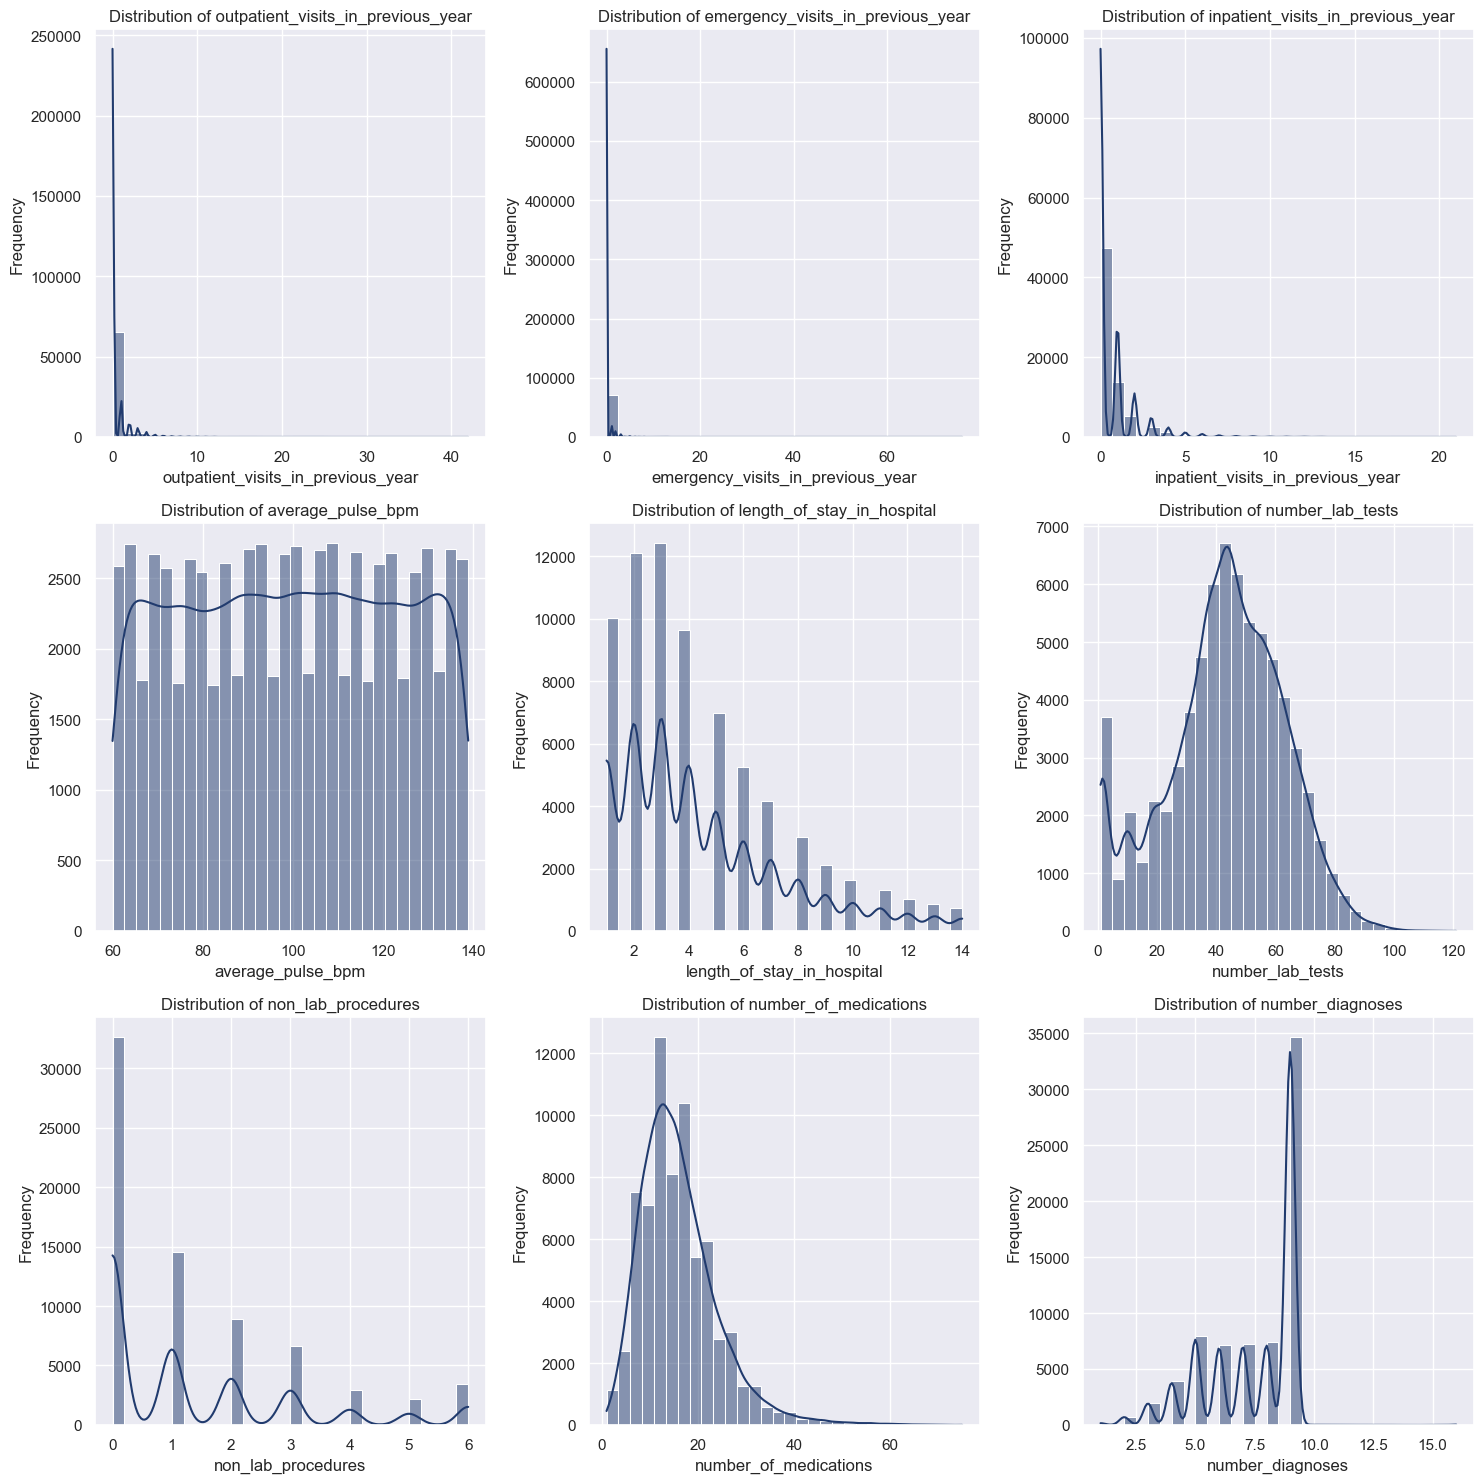

In [91]:
plots_per_row = 3

num_plots = len(metric_features)
num_rows = num_plots // plots_per_row + (1 if num_plots % plots_per_row else 0)

# Creating the plot
plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(metric_features, 1):
    plt.subplot(num_rows, plots_per_row, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

some insights given the graphs:

- `length_of_stay`, `number_lab_tests`, and `number of medications` look like skewed normal distributions, probably transfrom them using a log scale or with box-cox
- `number_of_diagnosis` and `non_lab_procedures` maybe can be treated as ordinals? since there are very few categories
- `averge_bpm` looks like invariant, please comment on this
- `x_in_previous_year` as metioned above, a possibility could be to create a new feature that is binomial, of whether is 0 or not.


#### Categorical Features Analysis


In [92]:
def describe_categorical(features, dataframe):
    # Initialize lists to store data for each column in the report
    feature_list = []
    mode_list = []
    mode_freq_list = []
    mode_prop_list = []
    second_mode_list = []
    second_mode_freq_list = []
    second_mode_prop_list = []
    missing_val_percent_list = []
    cardinality_list = []

    for feature in features:
        # Calculate mode, 2nd mode and their frequencies
        mode = dataframe[feature].mode()[0]
        mode_freq = dataframe[feature].value_counts().iloc[0]
        mode_prop = mode_freq / len(dataframe)
        second_mode = dataframe[feature].value_counts().index[1] if len(
            dataframe[feature].value_counts()) > 1 else 'N/A'
        second_mode_freq = dataframe[feature].value_counts().iloc[1] if len(
            dataframe[feature].value_counts()) > 1 else 0
        second_mode_prop = second_mode_freq / len(dataframe)

        # Calculate missing values percentage and cardinality
        missing_val_percent = dataframe[feature].isna().mean() * 100
        cardinality = dataframe[feature].nunique()

        # Append to lists
        feature_list.append(feature)
        mode_list.append(mode)
        mode_freq_list.append(mode_freq)
        mode_prop_list.append(mode_prop)
        second_mode_list.append(second_mode)
        second_mode_freq_list.append(second_mode_freq)
        second_mode_prop_list.append(second_mode_prop)
        missing_val_percent_list.append(missing_val_percent)
        cardinality_list.append(cardinality)

    # Create the DataFrame
    categorical_data_quality_report = pd.DataFrame({
        'Feature': feature_list,
        'Mode': mode_list,
        'Mode Frequency': mode_freq_list,
        'Mode Proportion': mode_prop_list,
        '2nd Mode': second_mode_list,
        '2nd Mode Frequency': second_mode_freq_list,
        '2nd Mode Proportion': second_mode_prop_list,
        'Missing Values %': missing_val_percent_list,
        'Cardinality': cardinality_list
    })

    return categorical_data_quality_report.sort_values(by=['Mode Proportion', 'Missing Values %'], ascending=False)

In [93]:
cat_info = describe_categorical(categorical_features, df).set_index("Feature")
cat_info.sort_values('Cardinality')

,Mode,Mode Frequency,Mode Proportion,2nd Mode,2nd Mode Frequency,2nd Mode Proportion,Missing Values %,Cardinality
Feature,,,,,,,,
country,USA,71236,1.000000,N/A,0,0.000000,0.000000,1
prescribed_diabetes_meds,Yes,54890,0.770537,No,16346,0.229463,0.000000,2
change_in_meds_during_hospitalization,No,38326,0.538014,Ch,32910,0.461986,0.000000,2
readmitted_binary,No,63286,0.888399,Yes,7950,0.111601,0.000000,2
gender,Female,38228,0.536639,Male,33005,0.463319,0.000000,3
readmitted_multiclass,No,38405,0.539123,>30 days,24881,0.349276,0.000000,3
a1c_test_result,none,59320,0.832725,>8,5705,0.080086,0.000000,4
glucose_test_result,none,67548,0.948228,Norm,1806,0.025352,0.000000,4
race,Caucasian,50693,0.711621,AfricanAmerican,12693,0.178182,7.117188,5


**insights**:

- `usa` invariant (we should drop)
- `glucose_test_result` and `a1c` (dominated by none)
- top 3 missing values:
  1. `weight` (we should drop)
  2. `medical_specialty`
  3. `payer_code`
- seems that `gender` and `change_in_meds` are the only ones that are boolean


##### Graphical Analysis


Index(['payer_code', 'medical_specialty', 'discharge_disposition',
       'admission_source', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'medication'],
      dtype='object')


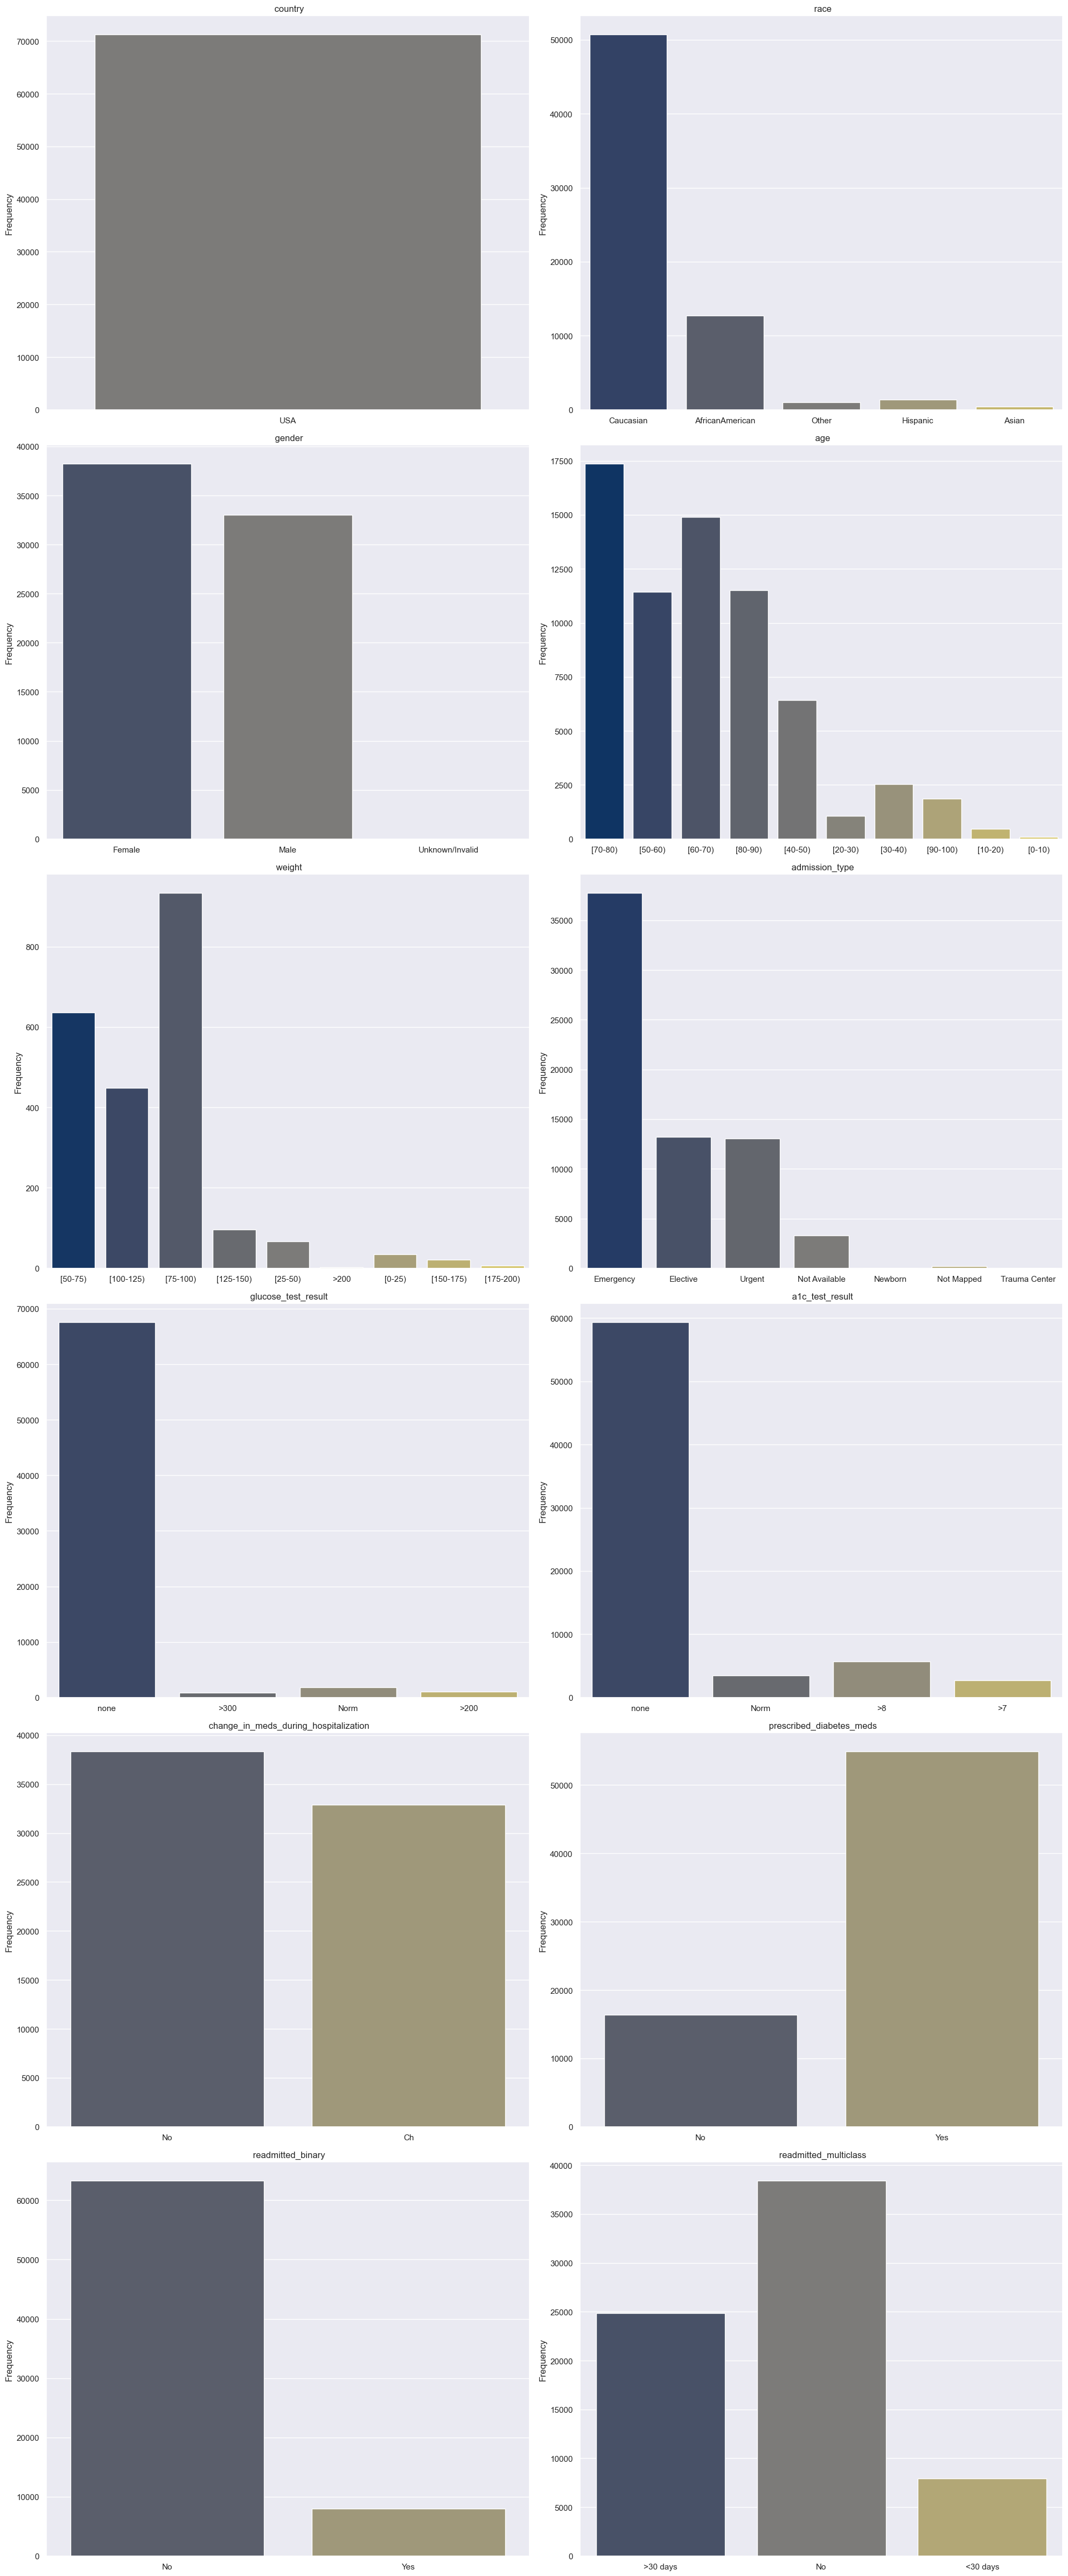

In [94]:
# Filtering out categorical features with low cardinality for visualization
low_cardinality_features = [
    feature for feature in categorical_features if cat_info.loc[feature, "Cardinality"] <= 10]

print(categorical_features[~categorical_features.isin(
    low_cardinality_features)])

# Adjusting the layout to display 2 bar plots per row for low cardinality features and increasing plot size
plots_per_row_low_cardinality = 2
num_rows_low_cardinality = len(low_cardinality_features) // plots_per_row_low_cardinality + \
    (1 if len(low_cardinality_features) % plots_per_row_low_cardinality else 0)

plt.figure(figsize=(20, num_rows_low_cardinality * 8))  # Increased figure size

for i, feature in enumerate(low_cardinality_features, 1):
    plt.subplot(num_rows_low_cardinality, plots_per_row_low_cardinality, i)
    sns.countplot(x=feature, data=df, palette='cividis')
    plt.title(f' {feature}')
    plt.ylabel('Frequency')
    plt.xlabel('')

plt.tight_layout()
plt.show()

comments on the graphs:

- `'payer_code', 'medical_specialty', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'medication'` have a lot of categories, re-size them or find a way to avoid having that much categories
- country invariant, so definitely drop it


#### Separation of Train and Validation


In [95]:
y = df["readmitted_binary"]
y_multi = df["readmitted_multiclass"]
df.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1, inplace=True)

In [96]:
X_train, X_val, y_train, y_val = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=69)

## Outlier Treatment


we will do some feature engineering to get rid of the outliers, it also will help to reduce the number of rows we are removing.

### Metric Features

will try not to delete the features, but just create a new column

In [97]:
def boxcox_transform(target: pd.DataFrame, columns: list):
    new_df = pd.DataFrame()
    for col in columns:
        transformed, _ = boxcox(target[col])
        new_df[col + "_log"] = transformed
    new_df.index = target.index
    return new_df

In [98]:
cols_to_log = ["length_of_stay_in_hospital", "number_lab_tests", "number_of_medications"]

log_train = boxcox_transform(X_train, cols_to_log)
X_train_bc = pd.concat([X_train, log_train], axis=1)

log_val = boxcox_transform(X_val, cols_to_log)
X_val_bc = pd.concat([X_val, log_val], axis=1)

X_val_bc.columns

Index(['country', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'length_of_stay_in_hospital_log', 'number_lab_tests_log',
       'number_of_medications_log'],
      dtype='object')

In [99]:
def metric_to_bool(target, columns, new_names):
    new_df = pd.DataFrame()
    for col, new_name in zip(columns, new_names):
        new_df[new_name] = target[col].astype(bool)
    new_df.index = target.index
    return new_df

In [100]:
cols_to_bool = ["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year"]

new_names = ["is_outpatient_visited", "is_emergency_visited", "is_inpatient_visited"]

bool_train = metric_to_bool(X_train_bc, cols_to_bool, new_names)
X_train_bool = pd.concat([X_train_bc, bool_train], axis=1)

bool_val = metric_to_bool(X_val_bc, cols_to_bool, new_names)
X_val_bool = pd.concat([X_val_bc, bool_val], axis=1)

a normal bpm is between 60-100 bpms [*source:wikipedia/hear_rate*](https://en.wikipedia.org/wiki/Heart_rate)

In [101]:
X_train_bool["is_pulse_normal"] = X_train_bool["average_pulse_bpm"].apply(lambda x: 60 <= x <= 100)

X_val_bool["is_pulse_normal"] = X_val_bool["average_pulse_bpm"].apply(lambda x: 60 <= x <= 100)

X_train_bool["is_pulse_normal"].describe()

count     56988
unique        2
top        True
freq      29007
Name: is_pulse_normal, dtype: object

In [102]:
## probably a good idea would be to windsorize all of the above right? and keep both of the vars

X_train_w = X_train_bool.copy()
X_val_w = X_val_bool.copy()

X_train_w["number_diagnoses"] = winsorize(X_train_w["number_diagnoses"], limits=[0, 0.01])
X_val_w["number_diagnoses"] = winsorize(X_val_w["number_diagnoses"], limits=[0, 0.01])

X_val_w["number_diagnoses"].describe()

count    14248.000000
mean         7.400197
std          1.927296
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max          9.000000
Name: number_diagnoses, dtype: float64

### Reducing Dimentionality of Categorical Features

In [103]:
# You can check International Statistical Classification of Diseases and Related Health Problems (https://en.wikipedia.org/wiki/List_of_ICD-9_codes)



def categorize_icd9_code(icd9_code):
    """
    Correctly categorize the given ICD-9 code based on the provided classification,
    including handling for 'E' and 'V' codes and ensuring all codes are treated as strings.
    """
    # Convert to string in case the code is not in string format
    code_str = str(icd9_code).strip()

    try:
        if code_str.startswith('E'):
            return 'External Causes of Injury and Supplemental Classification'
        elif code_str.startswith('V'):
            return 'Supplemental Classification of Factors Influencing Health Status'
        elif '.' in code_str:
            code = int(float(code_str))
        else:
            code = int(code_str)

        # Classify the code
        if 1 <= code <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        elif 240 <= code <= 279:
            return 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
        elif 280 <= code <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= code <= 319:
            return 'Mental Disorders'
        elif 320 <= code <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= code <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= code <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= code <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= code <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= code <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= code <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= code <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= code <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= code <= 799:
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif 800 <= code <= 999:
            return 'Injury and Poisoning'
        else:
            return 'Unknown or Invalid Code'
    except ValueError:
        # In case the code cannot be converted to an integer (e.g., '?')
        return 'Unknown or Invalid Code'


In [104]:
def categorize_discharged(x):
    category_dict = {
        "Discharged to home": "Home",
        "Discharged/transferred to home with home health service": "Home",
        "Hospice / home": "Home",
        "Discharged/transferred to home under care of Home IV provider": "Home",
        "Expired at home. Medicaid only, hospice.": "Home",
        "Discharged/transferred to another short term hospital": "Hospital",
        "Admitted as an inpatient to this hospital": "Hospital",
        "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital": "Hospital",
        "Discharged/transferred within this institution to Medicare approved swing bed": "Hospital",
        "Discharged/transferred/referred to this institution for outpatient services": "Hospital",
        "Neonate discharged to another hospital for neonatal aftercare": "Hospital",
        "Discharged/transferred/referred another institution for outpatient services": "Hospital",
        "Discharged/transferred to SNF": "Facility",
        "Discharged/transferred to ICF": "Facility",
        "Discharged/transferred to another type of inpatient care institution": "Facility",
        "Discharged/transferred to another rehab fac including rehab units of a hospital .": "Facility",
        "Discharged/transferred to a long term care hospital.": "Facility",
        "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.": "Facility",
        "Discharged/transferred to a federal health care facility.": "Facility",
        "Hospice / medical facility": "Other",
        "Expired": "Other",
        "Left AMA": "Other",
        "Not Mapped": "Other",
        "Expired in a medical facility. Medicaid only, hospice.": "Other",
        "Still patient or expected to return for outpatient services": "Other"
    }

    return category_dict.get(x, x)

In [105]:
def categorize_admission(x):
  trimmed = str(x).strip()
  category_dict = {
    "Emergency Room": "Emergency",
    "Physician Referral": "Referral",
    "Transfer from a hospital": "Transfer",
    "Transfer from another health care facility": "Transfer",
    "Clinic Referral": "Referral",
    "Transfer from a Skilled Nursing Facility (SNF)": "Transfer",
    "HMO Referral": "Referral",
    "Not Mapped": "Not Available",
    "Not Available": "Not Available",
    "Court/Law Enforcement": "Emergency",
    "Transfer from hospital inpt/same fac reslt in a sep claim": "Transfer",
    "Transfer from critial access hospital": "Transfer",
    "Transfer from Ambulatory Surgery Center": "Transfer",
    "Extramural Birth": "Other",
    "Normal Delivery": "Other",
    "Sick Baby": "Other"
  }
  
  return category_dict.get(trimmed, x)

In [106]:
X_train_reduced_cat = X_train_w.copy()
X_val_reduced_cat = X_val_w.copy()

X_train_reduced_cat['primary_diagnosis_cat'] = X_train_reduced_cat['primary_diagnosis'].apply(categorize_icd9_code)
X_train_reduced_cat['secondary_diagnosis_cat'] = X_train_reduced_cat['secondary_diagnosis'].apply(categorize_icd9_code)
X_train_reduced_cat['additional_diagnosis_cat'] = X_train_reduced_cat['additional_diagnosis'].apply(categorize_icd9_code)
X_train_reduced_cat["discharge_disposition_cat"] = X_train_reduced_cat["discharge_disposition"].apply(categorize_discharged)
X_train_reduced_cat["admission_source_cat"] = X_train_reduced_cat["admission_source"].apply(categorize_admission)

X_val_reduced_cat['primary_diagnosis_cat'] = X_val_reduced_cat['primary_diagnosis'].apply(categorize_icd9_code)
X_val_reduced_cat['secondary_diagnosis_cat'] = X_val_reduced_cat['secondary_diagnosis'].apply(categorize_icd9_code)
X_val_reduced_cat['additional_diagnosis_cat'] = X_val_reduced_cat['additional_diagnosis'].apply(categorize_icd9_code)
X_val_reduced_cat["discharge_disposition_cat"] = X_val_reduced_cat["discharge_disposition"].apply(categorize_discharged)
X_val_reduced_cat["admission_source_cat"] = X_val_reduced_cat["admission_source"].apply(categorize_admission)

In [107]:
new_cat_features = X_train_reduced_cat.select_dtypes(include='object').columns
cat_info = describe_categorical(new_cat_features, X_train_reduced_cat).set_index("Feature")
cat_info.sort_values('Cardinality')

,Mode,Mode Frequency,Mode Proportion,2nd Mode,2nd Mode Frequency,2nd Mode Proportion,Missing Values %,Cardinality
Feature,,,,,,,,
country,USA,56988,1.000000,N/A,0,0.000000,0.000000,1
prescribed_diabetes_meds,Yes,43945,0.771127,No,13043,0.228873,0.000000,2
change_in_meds_during_hospitalization,No,30570,0.536429,Ch,26418,0.463571,0.000000,2
gender,Female,30528,0.535692,Male,26458,0.464273,0.000000,3
glucose_test_result,none,54078,0.948937,Norm,1424,0.024988,0.000000,4
a1c_test_result,none,47476,0.833088,>8,4575,0.080280,0.000000,4
discharge_disposition_cat,Home,41405,0.726556,Facility,10179,0.178617,3.618306,4
race,Caucasian,40596,0.712360,AfricanAmerican,10181,0.178652,7.094476,5
admission_source_cat,Emergency,32314,0.567032,Referral,17299,0.303555,6.554011,5


In [108]:
def safe_convert_to_list(s):
    if s == "[]":
        return []
    try:
        return ast.literal_eval(s)
    except Exception:
        return []

# Create copies of the original dataframes
X_train_med = X_train_reduced_cat.copy()
X_val_med = X_val_reduced_cat.copy()

# Apply the conversion to an additional column in all new datasets
X_train_med['medication_list'] = X_train_med['medication'].apply(safe_convert_to_list)
X_val_med['medication_list'] = X_val_med['medication'].apply(safe_convert_to_list)

# Extract unique medications
unique_medications = set()
for dataset in [X_train_med, X_val_med]:
    for meds in dataset['medication_list']:
        unique_medications.update(meds)

# Function to create binary columns
def create_binary_med_columns(df, unique_meds):
    for med in unique_meds:
        df[f'med_{med}'] = df['medication_list'].apply(lambda meds: 1 if med in meds else 0)

# Apply the function to all new datasets
create_binary_med_columns(X_train_med, unique_medications)
create_binary_med_columns(X_val_med, unique_medications)

X_train_med.head().columns.tolist()

['country',
 'patient_id',
 'race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'admission_type',
 'medical_specialty',
 'average_pulse_bpm',
 'discharge_disposition',
 'admission_source',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'number_diagnoses',
 'glucose_test_result',
 'a1c_test_result',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'medication',
 'length_of_stay_in_hospital_log',
 'number_lab_tests_log',
 'number_of_medications_log',
 'is_outpatient_visited',
 'is_emergency_visited',
 'is_inpatient_visited',
 'is_pulse_normal',
 'primary_diagnosis_cat',
 'secondary_diagnosis_cat',
 'additional_diagnosis_cat',
 'discharge_disposition_cat',
 'admission_source_cat',
 'medication_list',
 'med_metformin-rosiglitazo

## Handling Missing Values

## Missing Values


In [133]:
X_train_filtered = X_train_med.copy() 
X_val_filtered = X_val_med.copy()

def missing_percentage(df):
    return df.isnull().mean() * 100


missing_percentage(X_train_filtered)

country                    0.000000
patient_id                 0.000000
race                       7.094476
gender                     0.000000
age                        5.023865
                             ...   
med_insulin                0.000000
med_glipizide              0.000000
med_glyburide-metformin    0.000000
med_nateglinide            0.000000
med_acarbose               0.000000
Length: 62, dtype: float64

In [134]:
features_to_drop = ['weight', 'country', 'medical_specialty', 'payer_code', 'medication_list', 'medication', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']

X_train_filtered = X_train_filtered.drop(features_to_drop, axis=1)
X_val_filtered = X_val_filtered.drop(features_to_drop, axis=1)

In [135]:
def replace_categorical_values(train_df, val_df, threshold=0.20):
    """
    Replace values in categorical features of training and testing datasets without altering the original dataframes.
    For features with more than 20% missing values, replace with 'Unknown'.
    For features with 20% or less missing values, replace with the mode of the training data.

    Parameters:
    X_train (DataFrame): The training dataset.
    X_test (DataFrame): The test dataset.
    threshold (float): The threshold for determining replacement strategy.

    Returns:
    DataFrame, DataFrame: New modified training and testing datasets.
    """
    # Creating copies of the dataframes to avoid altering the original data
    X_train_copy = train_df.copy()
    X_val_copy = val_df.copy()

    for col in X_train_copy.columns:
        if (X_train_copy[col].dtype == 'object' or X_train_copy[col].dtype.name == 'category'):
            missing_percentage = X_train_copy[col].isna(
            ).sum() / len(X_train_copy)

            if missing_percentage > threshold:
                # Replace with 'Unknown' for columns with more than 20% missing values
                X_train_copy[col].fillna('Unknown', inplace=True)
                X_val_copy[col].fillna('Unknown', inplace=True)
            else:
                # Replace with mode for columns with 20% or less missing values
                mode_value = X_train_copy[col].mode()[0]
                X_train_copy[col].fillna(mode_value, inplace=True)
                X_val_copy[col].fillna(mode_value, inplace=True)

    return X_train_copy, X_val_copy


X_train_treated, X_val_treated = replace_categorical_values(
    X_train_filtered, X_val_filtered)

probably in the future a good idea would be to use nearest neighbours to fill the data and test differences

In [136]:
missing_percentage(X_train_treated)

patient_id                               0.0
race                                     0.0
gender                                   0.0
age                                      0.0
outpatient_visits_in_previous_year       0.0
emergency_visits_in_previous_year        0.0
inpatient_visits_in_previous_year        0.0
admission_type                           0.0
average_pulse_bpm                        0.0
discharge_disposition                    0.0
admission_source                         0.0
length_of_stay_in_hospital               0.0
number_lab_tests                         0.0
non_lab_procedures                       0.0
number_of_medications                    0.0
number_diagnoses                         0.0
glucose_test_result                      0.0
a1c_test_result                          0.0
change_in_meds_during_hospitalization    0.0
prescribed_diabetes_meds                 0.0
length_of_stay_in_hospital_log           0.0
number_lab_tests_log                     0.0
number_of_

## Encoding


In [137]:
feat_to_encode = X_train_treated.select_dtypes(exclude=['number']).columns

cat_info = describe_categorical(feat_to_encode, X_train_treated).set_index("Feature")
cat_info.sort_values('Cardinality')

,Mode,Mode Frequency,Mode Proportion,2nd Mode,2nd Mode Frequency,2nd Mode Proportion,Missing Values %,Cardinality
Feature,,,,,,,,
is_emergency_visited,False,50513,0.886380,True,6475,0.113620,0.0,2
is_outpatient_visited,False,47663,0.836369,True,9325,0.163631,0.0,2
prescribed_diabetes_meds,Yes,43945,0.771127,No,13043,0.228873,0.0,2
is_inpatient_visited,False,37733,0.662122,True,19255,0.337878,0.0,2
is_pulse_normal,True,29007,0.509002,False,27981,0.490998,0.0,2
change_in_meds_during_hospitalization,No,30570,0.536429,Ch,26418,0.463571,0.0,2
gender,Female,30528,0.535692,Male,26458,0.464273,0.0,3
glucose_test_result,none,54078,0.948937,Norm,1424,0.024988,0.0,4
a1c_test_result,none,47476,0.833088,>8,4575,0.080280,0.0,4


In [138]:
def encode_features(train_df, val_df):
    """
    Encodes features in training and testing datasets using One-Hot Encoding if a column has 
    5 or fewer unique values, and Label Encoding if more than 5 unique values.

    Parameters:
    X_train (pd.DataFrame): The training dataset.
    X_test (pd.DataFrame): The test dataset.

    Returns:
    pd.DataFrame, pd.DataFrame: The encoded training and test datasets.
    """
    # Concatenate train and test sets to ensure consistent encoding
    # !!!this could be a source of data leakage
    combined = pd.concat([train_df, val_df], axis=0)
    ohe_features = train_df.select_dtypes(exclude=['number']).columns
    # for col in combined.columns:
    #     if (combined[col].dtype == 'object' or combined[col].dtype == 'category' or combined[col].dtype == 'bool'):
    #         # if combined[col].nunique() <= 5:
    #         #     # Apply One-Hot Encoding
    #         #     # dummies = pd.get_dummies(combined[col], prefix=col)
    #         #     # combined = pd.concat([combined.drop(col, axis=1), dummies], axis=1)
    #         #     low_cardinallity.append(col)
    #         #     # hot_encoder = OneHotEncoder(drop='first')
    #         #     # combined[col] = hot_encoder.fit_transform(combined[col])
    #         #     # t_df[col] = hot_encoder.transform(t_df[col])
    #         if 5 <= combined[col].nunique() <= 10:
    #             # Apply Label Encoding
    #             le = LabelEncoder()
    #             combined[col] = le.fit_transform(combined[col])
    #             t_df[col] = le.transform(t_df[col])
    #             # oe_features.append(col)
    #         else:
    #             # apply hot encoder grouping categories in max 5 cat
    #             ohe_features.append(col)
    #             # hot_encoder = OneHotEncoder(drop='first', max_categories=5)
    #             # combined[col] = hot_encoder.fit_transform(combined[col])
    #             # t_df[col] = hot_encoder.transform(t_df[col])

    hot_encoder = OneHotEncoder(
        sparse=False, drop='first', handle_unknown='ignore')
    # label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    # encoding the training and validation sets
    ohe_combined = hot_encoder.fit_transform(combined.loc[:, ohe_features])
    ohe_names = hot_encoder.get_feature_names_out()
    ohe_df = pd.DataFrame(
        ohe_combined, index=combined.index, columns=ohe_names)

    # le_combined = label_encoder.fit_transform(combined.loc[:, oe_features])
    # le_names = label_encoder.get_feature_names_out()
    # le_df = pd.DataFrame(le_combined, index=combined.index, columns=le_names)

    # encoding the test set, with the training encoder
    # ohe_test = hot_encoder.transform(t_df.loc[:, ohe_features])
    # ohe_t_df = pd.DataFrame(ohe_test, index=t_df.index, columns=ohe_names)

    # le_test = label_encoder.transform(t_df.loc[:, oe_features])
    # le_t_df = pd.DataFrame(le_test, index=t_df.index, columns=le_names)

    combined = combined.drop(ohe_features, axis=1)
    # t_df = t_df.drop(ohe_features, axis=1)

    # merging the new encoded
    combined = combined.merge(ohe_df, on='encounter_id')
    # t_df = t_df.merge(ohe_t_df, on='encounter_id')

    # Split the combined dataset back into training and testing sets
    train = combined.iloc[:len(train_df), :]
    validation = combined.iloc[len(train_df):, :]

    return train, validation

In [139]:
X_train_encoded, X_val_encoded, = encode_features(
    X_train_treated, X_val_treated)

In [140]:
X_train_encoded.shape

(56988, 166)

In [142]:
X_train_treated.select_dtypes(include=['number']).columns

Index(['patient_id', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses',
       'length_of_stay_in_hospital_log', 'number_lab_tests_log',
       'number_of_medications_log', 'med_metformin-rosiglitazone',
       'med_glimepiride', 'med_tolbutamide', 'med_miglitol', 'med_repaglinide',
       'med_troglitazone', 'med_rosiglitazone', 'med_acetohexamide',
       'med_glimepiride-pioglitazone', 'med_tolazamide', 'med_metformin',
       'med_pioglitazone', 'med_glipizide-metformin', 'med_chlorpropamide',
       'med_metformin-pioglitazone', 'med_glyburide', 'med_insulin',
       'med_glipizide', 'med_glyburide-metformin', 'med_nateglinide',
       'med_acarbose'],
      dtype='object')

In [149]:
new_metric_features = X_train_bc.select_dtypes(include=['number']).columns

new_metric_features

Index(['patient_id', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses',
       'length_of_stay_in_hospital_log', 'number_lab_tests_log',
       'number_of_medications_log'],
      dtype='object')

In [150]:
scaler = RobustScaler()
X_train_encoded_num = scaler.fit_transform(X_train_encoded[new_metric_features])
X_val_encoded_num = scaler.transform(X_val_encoded[new_metric_features])

In [151]:
X_train_encoded[new_metric_features] = X_train_encoded_num
X_val_encoded[new_metric_features] = X_val_encoded_num

In [152]:
X_train_encoded.head()

,patient_id,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,...,additional_diagnosis_cat_Supplemental Classification of Factors Influencing Health Status,"additional_diagnosis_cat_Symptoms, Signs, and Ill-defined Conditions",additional_diagnosis_cat_Unknown or Invalid Code,discharge_disposition_cat_Home,discharge_disposition_cat_Hospital,discharge_disposition_cat_Other,admission_source_cat_Not Available,admission_source_cat_Other,admission_source_cat_Referral,admission_source_cat_Transfer
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,0.852841,0.0,0.0,0.0,-0.175,-0.25,0.730769,1.5,1.7,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
794587,-0.659507,0.0,0.0,0.0,-0.650,0.50,0.538462,-0.5,-0.8,-0.666667,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
694232,-0.337133,0.0,0.0,0.0,-0.425,-0.50,-0.576923,0.0,-0.8,-1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
305869,-0.423818,0.0,0.0,3.0,-0.825,-0.50,-0.346154,-0.5,-1.0,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
181753,-0.058924,0.0,0.0,0.0,0.650,0.00,-0.153846,0.0,0.1,-0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Balancing Data

Q: since we are balancing, when selecting the features, it would take into account the data balanced? wouldnt it be biasing?

In [153]:
def balance_data(X_to_balance, y_imbalanced):
  bs = BorderlineSMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=5, m_neighbors=10, kind='borderline-2')
  
  x_train_resampled, y_resampled = bs.fit_resample(X_to_balance, y_imbalanced)
  return x_train_resampled, y_resampled

In [156]:
X_train_balanced, y_balanced = balance_data(X_train_encoded, y_train)

y_balanced.describe()

count     75942
unique        2
top          No
freq      50628
Name: readmitted_binary, dtype: object